# Reconnaissance de chiffres manuscrits

Dans ce projet, un modèle de reconnaissance de chiffres manuscrits est developpé, en utilisant PyTorch et des techniques de deep learning. L’objectif est de concevoir et d’entraîner un réseau de neurones capable d’identifier correctement les chiffres à partir d’images d’entrée.

L'ensemble de données contient des images de chiffres qui sont transformées en tenseurs pour être exploitables par le modèle. Un Dataset personnalisé est mis en place pour faciliter le chargement des données et leur gestion. 

Ce projet permet d’explorer les concepts fondamentaux du deep learning, tels que la manipulation des tenseurs, la construction de réseaux de neurones et l’optimisation des hyperparamètres pour améliorer les prédictions.

## Importation des données 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
import torch 
from torch.utils.data import DataLoader, Dataset
import torchvision 
import torch.nn as nn 
from torch.optim import SGD
import torch.nn.functional as F

Le jeu de données a été importé depuis : www.di.ens.fr/~lelarge/MNIST.tar.gz

Il est composé de deux parties : un training set et un test set. Nous allons d'abord importer le training set sans transformer les données afin de voir à quoi ressemble le dataset, puis nous allons créer un dataset personnalisé pour le prétraitement.

In [3]:
X, y = torch.load('training.pt')

In [4]:
X.shape

torch.Size([60000, 28, 28])

Le training dataset comporte 60000 images de taille 28 pixels par 28 pixels. La variable à expliquer comporte quant à elle 60000 éléments. 

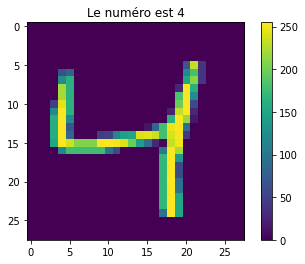

In [5]:
plt.imshow(X[2])
# avant il fallait mettre .numpy() mais plus besoin maintenant 

# Si X[2] est un tenseur stocké sur GPU, alors .numpy() va générer une erreur, car les tenseurs sur GPU ne peuvent pas 
# être directement convertis en NumPy. Dans ce cas, il faut d'abord le déplacer sur le CPU :
plt.title(f'Le numéro est {y[2]}')
plt.colorbar()


In [6]:
X.view(-1, 28**2).shape

# on avait 3 dimensions mais dans notre nn il faut que 2 dimensions. Au début il y avait 60000 images 28*28 mais maintenant 
# c'est 60000 vecteurs à 784 éléments

torch.Size([60000, 784])

## Transformation des données

Tout d'abord nous devons normaliser les images. La normalisation des images consiste à ramener les valeurs des pixels dans une intervalle plus restreint, entre 0 et 1. C'est important, car des valeurs trop grandes peuvent rendre l’entraînement du modèle instable. En effet, sans normalisation, les poids des neurones subiront des mises à jour trop instables, car les grandes valeurs domineront l'apprentissage au détriment des plus petites.

Il faut également effectuer un One-Hot Encoding pour la variable à expliquer **y**. Le One-Hot Encoding est une méthode de représentation des labels sous forme de vecteurs binaires.
Nous effectuons cela car le One-Hot Encoding permet au modèle de calculer la perte plus précisément en comparant directement les probabilités prédites avec les labels.

In [7]:
class NouveauDataset(Dataset):
    def __init__(self, chemin):
        self.X, self.y = torch.load(chemin)
        self.X = self.X / 255
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        return self.X[ix], self.y[ix]

Les fonctions **len** et **getitem** permettent de faciliter la gestion de données. 

**Note** : Notre classe "NouveauDataset" hérite de la classe Dataset de PyTorch

**Hériter** signifie que la classe NouveauDataset est une sous-classe de Dataset du module PyTorch. Cela signifie que NouveauDataset reprend toutes les fonctionnalités de Dataset et peut les étendre ou les modifier en redéfinissant certaines méthodes.

### Création des train dataset et test dataset

In [8]:
train_ds = NouveauDataset('training.pt')
test_ds = NouveauDataset('test.pt')

In [9]:
# FAIRE ATTENTION AUX MAJUSCULES 

In [10]:
len(train_ds)

60000

In [11]:
X.shape[0]

60000

### Dataloader

Nous allons à présent créer un Dataloader. Voici ses principales fonctions et utilités :

Chargement par lots (Batching) :

Au lieu de charger toutes les données d'un coup (ce qui pourrait être très coûteux en mémoire), un DataLoader divise les données en batches (lots). Cela permet de traiter les données de manière plus efficace et d'éviter les problèmes de mémoire.

Shuffling (Mélange des données) :

Lors de l'entraînement, il est souvent important de mélanger les données pour éviter que le modèle ne surapprenne un ordre particulier de données. Le DataLoader peut mélanger les données à chaque epoch (itération sur l'ensemble des données), ce qui contribue à améliorer la généralisation du modèle.

In [12]:
train_dl = DataLoader(train_ds, batch_size=5)

In [13]:
# ça forme des groupes de 5

# Fonction coût 

In [14]:
L = nn.CrossEntropyLoss()

La fonction coût que nous utilisons est la Cross Entropy Loss ou encore appelée Log loss. Elle mesure la différence entre les probabilités prédites par le modèle et les vraies classes (labels). Elle pénalise fortement les mauvaises prédictions et est idéale pour la classification, car elle pousse le modèle à donner une probabilité élevée à la classe correcte.

# Modèle

Les images utilisées sont des matrices 2D de taille 28*28, Cependant, les entrées de notre réseau de neurones doivent être des vecteurs

- Conversion d’une image 28×28 en un vecteur de 784 valeurs

Une image de 28×28 pixels contient 784 valeurs (une par pixel).
En la transformant en vecteur de 784 dimensions, chaque pixel devient une entrée du réseau de neurones.
Cela permet aux couches de manipuler les pixels comme une série de valeurs dans un espace de grande dimension.

In [15]:
class RN(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrice1 = nn.Linear(28**2, 100)
        self.Matrice2 = nn.Linear(100, 50)
        self.Matrice3 = nn.Linear(50, 10)
        self.R = nn.ReLU()
        
    def forward(self, x):
        x = x.float()
        x = x.view(-1, 28**2)
        x = self.R(self.Matrice1(x))
        x = self.R(self.Matrice2(x))
        x = self.Matrice3(x)
        return x.squeeze()
        

# quand on est dans l'argument pas besoin de mettre self

Le réseau de neurones est composé de trois couches contenant respectivement 100, 50 et 10 neurones. La dernière couche doit en comporter 10 afin d'estimer les probabilités. Les deux premières couches utilisent la fonction d'activation ReLU.

La fonction squeeze() est utilisée dans des bibliothèques comme NumPy et PyTorch pour retirer les dimensions de taille 1 
d'un tableau ou d'un tenseur.

**Remarque importante** : le nombre de neurones choisi pour chaque couche est arbitraire. Nous aurions pu procéder autrement.

**Note** : Notre classe "RN" hérite de la classe "nn.Module" de PyTorch

In [16]:
f = RN()

In [17]:
xs, ys = train_ds[0:4]

In [18]:
xs.dtype

torch.float32

In [19]:
ys

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [20]:
f(xs)

tensor([[ 0.0762, -0.2142, -0.0195, -0.0737,  0.0135, -0.0657,  0.0119, -0.1012,
          0.1232, -0.0226],
        [ 0.0765, -0.2400, -0.0110, -0.0629, -0.0369, -0.0704,  0.0515, -0.1199,
          0.1414, -0.0420],
        [ 0.1010, -0.1975, -0.0166, -0.0476, -0.0104, -0.0789,  0.0152, -0.1629,
          0.1224, -0.0373],
        [ 0.1097, -0.2138,  0.0145, -0.0558, -0.0174, -0.0802,  0.0085, -0.1381,
          0.1336, -0.0831]], grad_fn=<SqueezeBackward0>)

In [21]:
f(xs).argmax(axis=1)

tensor([8, 8, 8, 8])

In [22]:
L(f(xs), ys)

tensor(2.3301, dtype=torch.float64, grad_fn=<DivBackward1>)

Nous obtenons une perte totale de 2.3326 ce qui est élevé mais normal car le modèle n'a pas encore été entraîné. Les paramètres ont été initialisés de manière aléatoire. 

## Entraînement du modèle

Avant de passer à l'entraînement du modèle, clarifions quelques notions de vocabulaire : 

- epoch = une itération complète de notre jeu de données

- batch = le jeu de données est divisé en sous groupes, car traiter toutes les données d'un coup peut être inefficace en mémoire et en calcul.

Exemple : Si on a 10 000 images et qu'on utilise un batch size de 100, cela signifie qu’il faudra 100 itérations 
pour compléter 1 epoch.

In [23]:
def training_model(dl, f, n_epochs=20):
    # optimisation 
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()
    
    # entraînement 
    loss = []
    epochs = []
    
    for epoch in range(n_epochs): # quand c'est une liste pas besoin de mettre range mais là, c'est un int donc il faut range
        print(f'Epoch : {epoch}')
        N = len(dl)
        
        for i, (x,y) in enumerate(dl): 
        # ici il va faire 12000 itérations car chaque élément contient 5 valeurs 
        # x est l'image et y est le label
            opt.zero_grad() # car sinon les GRADIENTS s'accumulent, toujours le mettre avant le backward
            loss_value = L(f(x), y)
            loss_value.backward() 
            opt.step() # mise à jour des POIDS
            
            epochs.append(epoch+i/N)  # comme ça on a le L (loss) pour chaque batch de chaque epochs
            loss.append(loss_value.item()) # item() parce que c'est un tensor et qu'on veut que la valeur 
    return(np.array(epochs), np.array(loss)) # on convertit en array car sur plt, les listes sont pas adaptées   
                                             # le type quand c'est une liste est list mais pour array c'est float

In [24]:
epoch_data, loss_data = training_model(train_dl, f) # d'où l'utilité du dataloader

Epoch : 0
Epoch : 1
Epoch : 2
Epoch : 3
Epoch : 4
Epoch : 5
Epoch : 6
Epoch : 7
Epoch : 8
Epoch : 9
Epoch : 10
Epoch : 11
Epoch : 12
Epoch : 13
Epoch : 14
Epoch : 15
Epoch : 16
Epoch : 17
Epoch : 18
Epoch : 19


In [25]:
loss_data.dtype

dtype('float64')

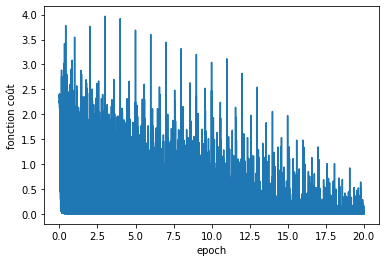

In [26]:
plt.plot(epoch_data, loss_data)
plt.xlabel('epoch')
plt.ylabel('fonction coût')
plt.show()

Dans notre modèle, nous avons calculé le coût (L) pour chaque batch à chaque epoch. Étant donné qu'un batch contient 5 images (ou vecteurs dans notre modèle) et qu'il y a 60 000 images au total, chaque epcoh implique le calcul de 12 000 fonctions coût.

Avec 20 epochs, cela représente un total de 240 000 fonctions coût calculées.

Nous observons qu'au fur et à mesure de l'entraînement, les erreurs du modèle diminuent.

In [27]:
loss_data.shape

(240000,)

Nous avons bien 240 000 fonctions de coût calculées. Cependant, ce que nous cherchons à obtenir n'est pas le coût pour chaque batch de chaque epoch, mais le coût moyen par epoch afin de vérifier si les erreurs du modèle diminuent au fil de l'entraînement. Ainsi, pour chaque epoch, nous calculons la moyenne de la fonction coût.

In [28]:
loss_data = np.array(loss_data)

In [29]:
loss_data_moyenne = loss_data.reshape(20, -1).mean(axis=1)
epoch_data_moyenne = epoch_data.reshape(20, -1).mean(axis=1)

In [30]:
loss_data_moyenne.shape

(20,)

Text(0.5, 1.0, 'Cross Entropy')

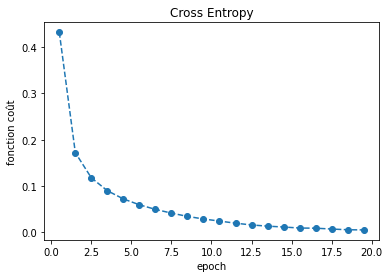

In [31]:
plt.plot(epoch_data_moyenne, loss_data_moyenne, 'o--')
plt.xlabel('epoch')
plt.ylabel('fonction coût')
plt.title('Cross Entropy')

In [32]:
loss_data_moyenne

array([0.43223323, 0.17216668, 0.11785437, 0.08994777, 0.0722837 ,
       0.05959449, 0.0496796 , 0.04158989, 0.03455244, 0.02892069,
       0.02440682, 0.01984769, 0.0160496 , 0.01344502, 0.01158896,
       0.00938802, 0.00903322, 0.00723141, 0.00567287, 0.00531437])

Nous constatons qu'au fur et à mesure de l'entraînement, les erreurs du modèle diminuent. Au début, l'erreur était de 0.44 pour atteindre 0.004 à la fin.

# Vérification 

Nous devons à présent déterminer la classe prédite par notre modèle pour chaque image. Pour cela, nous utilisons une couche argmax. La fonction argmax retourne l’index de la plus grande valeur dans le tenseur. 

In [33]:
xs2, ys2 = train_ds[0:200]
yhat = f(xs2).argmax(axis=1)

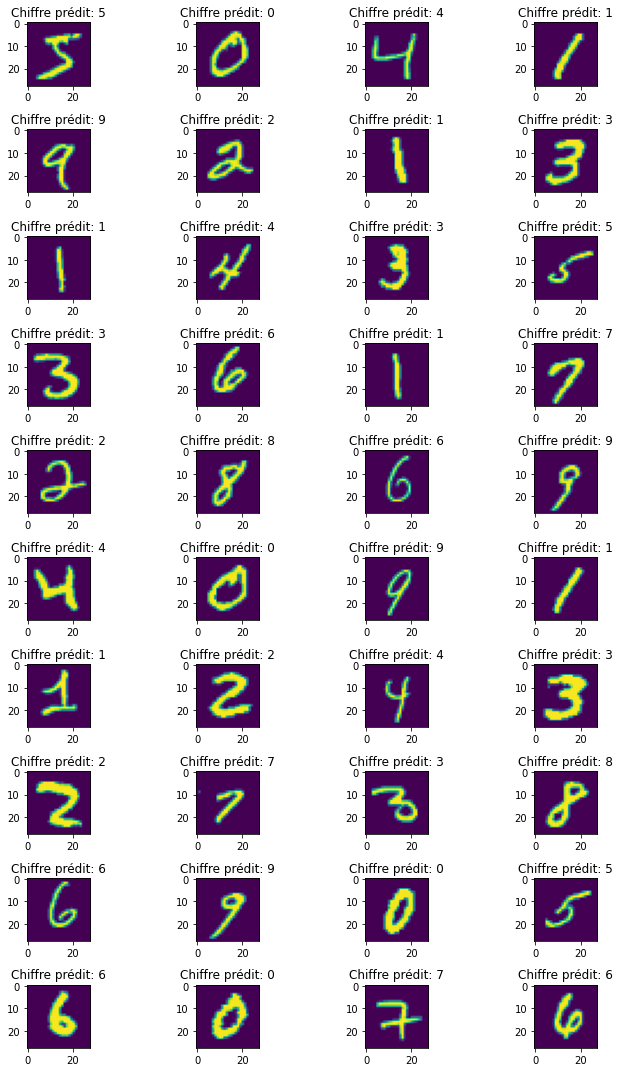

In [34]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs2[i])
    plt.title(f'Chiffre prédit: {yhat[i]}')
fig.tight_layout() # pour une meilleure présentation
plt.show()


# ATTENTION, il y a SUBPLOTS et SUBPLOT
# Subpolts : c'est pour créer la structure de la figure 
# Subplot : c'est pour dire où afficher l'image à chaque itération, il y a 3 arguments dans celui ci, le dernier est pour dire 
# où va se situer le sous graphe i
# Attention, l'indice commence à 1 c'est pour cela que l'on met i+1

Le modèle est performant, il arrrive à correctement prédire les chiffres manuscrits. 

## Vérification avec le test set

Il faut maintenant vérifier si le modèle souffre de surapprentissage ou de sous-apprentissage des données. C'est là qu'intervient le test set, car le modèle n'a jamais vu ces images.

In [35]:
xt, yt = test_ds[0:2000]
yt_hat = f(xt).argmax(axis=1)

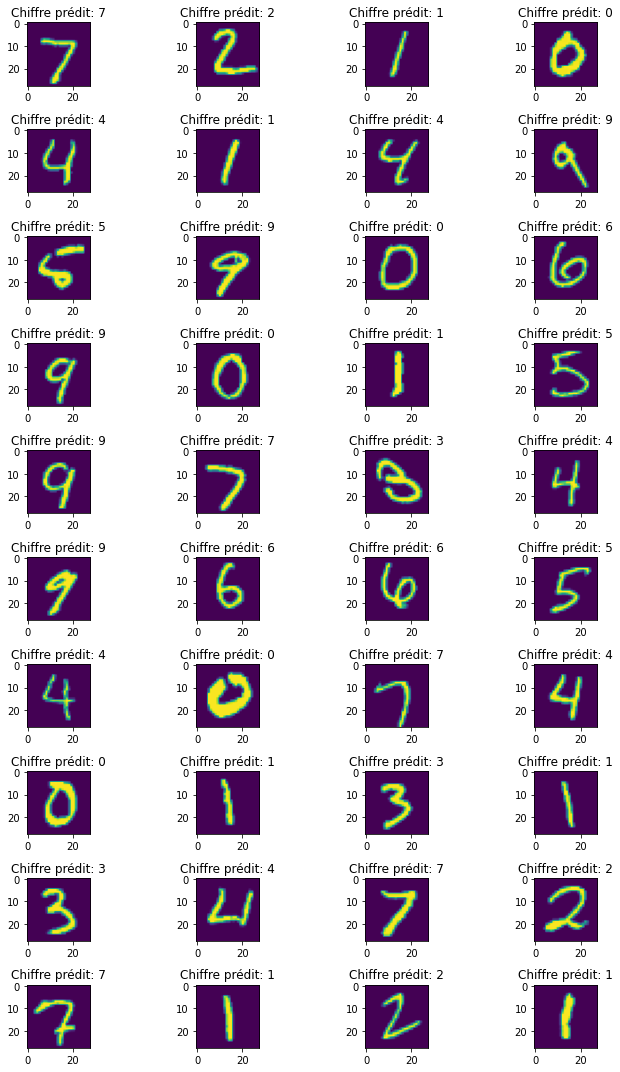

In [36]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xt[i])
    plt.title(f'Chiffre prédit: {yt_hat[i]}')
fig.tight_layout() # pour une meilleure présentation
plt.show()

Le modèle est très bon car il n'y pas de surapprentissage.

# Conclusion 

En conclusion, notre modèle montre de très bonnes performances dans la reconnaissance des chiffres manuscrits. En effet, il est capable de prédire avec précision, sans surapprentissage, comme l'indique l'évaluation sur le test set. Les erreurs du modèle diminuent significativement au fil des epochs, ce qui témoigne de l'efficacité de l'apprentissage. Ainsi, nous pouvons affirmer que le modèle est bien entraîné et qu'il généralise correctement sur de nouvelles données.